# Pre-process

## Package & Datasets loading

In [1]:
import pandas as pd
import numpy as np
import re
import stanza
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

/home/hao/Code/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('punkt')  
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/hao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/hao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/hao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/hao/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# stanza.download('en')
# nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment', tokenize_no_ssplit=True)

In [4]:
df = pd.read_csv('../../Final_Datasets/TA_combined_df_City_tourism_type_VADER_final_Stanza.csv')
df

,Hotel_locID,Hotel_geoID_x,Review_id,Review_Date,Date_of_stay,Reviewer_Contributions,Reviewer_helpful_vote,Review_Rating,Trip_type,Review_helpful_votes,...,Resaurant_count,Attractions_count,Hotel_styles,Popular_mentions,WordCount,Title,Review,Compound_Score,Unreliable,Stanza_Score
0,23448880,60763,916928494,Sep 16,September 2023,0,0,1,Traveled on business,1,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",66,Unfriendly staff and dirty,I travel a lot - and I am in general very flex...,-0.4095,0,0
1,23448880,60763,828890910,Feb 2022,February 2022,45,26,5,NaN,8,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",115,Perfect for Us,We recently chose Motto for an overnight in NY...,0.9903,0,2
2,23448880,60763,915189618,Sep 6,September 2023,0,0,3,Traveled on business,0,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",99,Not satisfied with the overall experience,The rooms are two small for the price that you...,-0.0121,0,0
3,23448880,60763,915010751,Sep 5,September 2023,68,88,5,Traveled with family,1,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",152,Magnificent Motto - fantastic staff,I have just returned home after a five day sta...,0.9746,0,2
4,23448880,60763,914794870,Sep 4,August 2023,179,68,5,Traveled solo,0,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",201,Worthy of a 5-star rating!,I did not believe the overwhelming 5-star revi...,0.9949,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65977,12841013,35805,536016764,Oct 2017,October 2017,0,0,4,Traveled solo,0,...,209.0,90.0,[],[],107,Great cost benefit,I stayed in the loop suites from 10/19/17 to 1...,0.9891,0,2
65978,12841013,35805,535664344,Oct 2017,October 2017,0,0,5,Traveled solo,0,...,209.0,90.0,[],[],43,AWESOME,I enjoy my stay! Very nice and very clean and ...,0.9703,0,2
65979,12841013,35805,535094403,Oct 2017,January 2017,0,0,5,Traveled solo,0,...,209.0,90.0,[],[],46,"Very good hotel, highly recommended",I've stayed in this apartment hotel in January...,0.7639,0,2
65980,12841013,35805,531949578,Oct 2017,May 2017,0,0,1,Traveled as a couple,0,...,209.0,90.0,[],[],158,Shocking,"We booked an apartment for 4 people, 2 couples...",-0.5707,0,0


In [5]:
df['Hotel_locID'].nunique()

704

## Data Overview & Labeling

In [6]:
# VADER
def calculate_compound_score(review):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(review)['compound']

# Unreliable tag
def calculate_unreliable(row):
    compound_score = row['Compound_Score']
    rating = row['Review_Rating']
    
    if (compound_score < -0.49 and rating >= 3):
        return 1
    else:
        return 0

# Stanza
# def analyze_sentiment(text):
#   doc = nlp(text)
#   sentiments = [sentence.sentiment for sentence in doc.sentences]
  
#   compound_score = sentiments[0]
#   return compound_score

# Stanza x iterations
def analyze_sentiment(text):
    compound_scores = []
    num_iterations=11
    for _ in range(num_iterations):
        doc = nlp(text)
        sentiments = [sentence.sentiment for sentence in doc.sentences]
        compound_scores.append(sentiments[0])
    
    most_common_sentiment = Counter(compound_scores).most_common(1)
    # print(compound_scores)
    
    return most_common_sentiment[0][0]

# Stanza Unreliable tag
def calculate_unreliable_stanza(row):
    stanza_score = row['Stanza_Score']
    rating = row['Review_Rating']
    
    if (stanza_score == 2 and rating < 3) or (stanza_score == 0 and rating >= 3):
        return 1
    else:
        return 0

In [7]:
df['Unreliable'] = df.apply(calculate_unreliable, axis=1)
print(df['Unreliable'].value_counts())

Unreliable
0    64966
1     1016
Name: count, dtype: int64


In [8]:
# df['Stanza_Score'] = df['Review'].apply(analyze_sentiment)

In [9]:
# Unreliable reviews example
unreliable_reviews = df[df['Unreliable'] == 1]['Review']
unreliable_reviews.head(10)

133    Nice central location in Time Square with Pool...
209    I was supposed to stay here the weekend of the...
211    No service at all. Good location. No recogniti...
265    Anthony Lydia and the front desk agents are aw...
518    The room is too smaller for the high price, an...
548    Clogged sink would not drain. I appreciated th...
609    The charge for holding baggage while waiting f...
652    just ok - not pleased with shower (very weird ...
659    Title says it all. Better places to stay. Desk...
947    The hotel itself seems a little dated on the i...
Name: Review, dtype: object

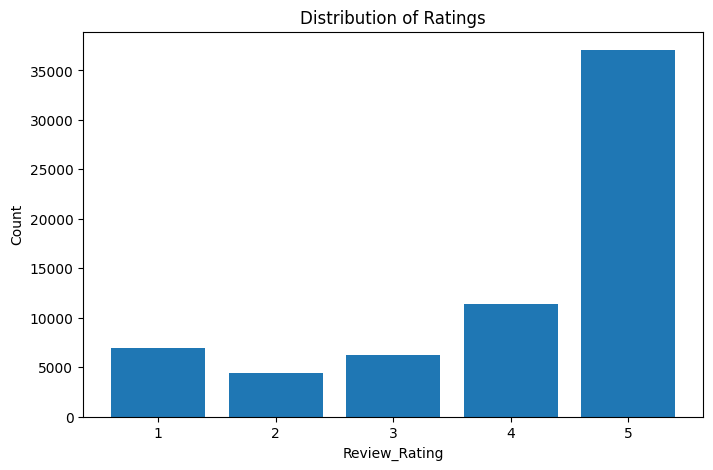

In [10]:
# Reviews rating distributions
rating_counts = df['Review_Rating'].value_counts()
rating_counts = rating_counts.sort_index()
plt.figure(figsize=(8, 5))  # size
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Review_Rating')  
plt.ylabel('Count')  
plt.title('Distribution of Ratings')  
plt.show()

## Function

In [11]:
def decontracting(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'bout", "about", text)
    text = re.sub(r"\'til", "until", text)
    return text

stopwords_list = stopwords.words('english')
def remove_stopwords(tokens):
    texts = [i for i in tokens if i not in stopwords_list]
    return texts


def lemmatization(tokens):
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  return lemmatized_tokens


def word_preprocess(df, column_name):
  #lowercase
  df[column_name] = df[column_name].apply(lambda x: str(x).lower())

  #decontracting
  df[column_name] = df[column_name].apply(decontracting)

  #remove tags, punctuations, numbers
  df[column_name] = df[column_name].apply(lambda x: re.sub('[^a-zA-Z!]', ' ', x))

  #tokenization
  import nltk
  nltk.download('punkt')
  df[column_name] = df[column_name].apply(lambda x: nltk.word_tokenize(x))

  #remove stopwords
  df[column_name] = df[column_name].apply(remove_stopwords)
  return df

## Text Preprocess

In [12]:
text_preprocessed_df = word_preprocess(df,'Review')

[nltk_data] Downloading package punkt to /home/hao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
text_preprocessed_df['Review']

0        [travel, lot, general, flexible, easy, hotels,...
1        [recently, chose, motto, overnight, nyc, glad,...
2        [rooms, two, small, price, pay, better, hotel,...
3        [returned, home, five, day, stay, new, york, w...
4        [believe, overwhelming, star, reviews, propert...
                               ...                        
65977    [stayed, loop, suites, found, valid, !, arrive...
65978    [enjoy, stay, !, nice, clean, good, looking, a...
65979    [stayed, apartment, hotel, january, studio, cl...
65980    [booked, apartment, people, couples, arrived, ...
65981    [sorry, english, write, everyone, understand, ...
Name: Review, Length: 65982, dtype: object

In [14]:
# delete nan row
text_preprocessed_df = text_preprocessed_df.dropna(subset=['Hotel_star', 'Review_Rating', 'Review', 'Reviewer_Contributions'])

In [15]:
text_preprocessed_df['Hotel_locID'].nunique()

620

In [16]:
text_preprocessed_df['Review_Rating'].mean()

3.9918591822406473

In [17]:
rating_counts = text_preprocessed_df['Review_Rating'].value_counts()
rating_proportions = text_preprocessed_df['Review_Rating'].value_counts(normalize=True)

# 打印計數和比例
print("Rating counts:\n", rating_counts)
print("Rating proportions:\n", rating_proportions)

Rating counts:
 Review_Rating
5    33033
4    10399
1     6513
3     5773
2     4104
Name: count, dtype: int64
Rating proportions:
 Review_Rating
5    0.552188
4    0.173832
1    0.108873
3    0.096503
2    0.068604
Name: proportion, dtype: float64


## Split datasets to sub-datasets

In [18]:
text_preprocessed_df

,Hotel_locID,Hotel_geoID_x,Review_id,Review_Date,Date_of_stay,Reviewer_Contributions,Reviewer_helpful_vote,Review_Rating,Trip_type,Review_helpful_votes,...,Resaurant_count,Attractions_count,Hotel_styles,Popular_mentions,WordCount,Title,Review,Compound_Score,Unreliable,Stanza_Score
0,23448880,60763,916928494,Sep 16,September 2023,0,0,1,Traveled on business,1,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",66,Unfriendly staff and dirty,"[travel, lot, general, flexible, easy, hotels,...",-0.4095,0,0
1,23448880,60763,828890910,Feb 2022,February 2022,45,26,5,NaN,8,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",115,Perfect for Us,"[recently, chose, motto, overnight, nyc, glad,...",0.9903,0,2
2,23448880,60763,915189618,Sep 6,September 2023,0,0,3,Traveled on business,0,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",99,Not satisfied with the overall experience,"[rooms, two, small, price, pay, better, hotel,...",-0.0121,0,0
3,23448880,60763,915010751,Sep 5,September 2023,68,88,5,Traveled with family,1,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",152,Magnificent Motto - fantastic staff,"[returned, home, five, day, stay, new, york, w...",0.9746,0,2
4,23448880,60763,914794870,Sep 4,August 2023,179,68,5,Traveled solo,0,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",201,Worthy of a 5-star rating!,"[believe, overwhelming, star, reviews, propert...",0.9949,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65954,290675,35805,17172887,Jun 2008,June 2008,0,2,4,Traveled with family,0,...,NaN,NaN,[],[],78,Loved the Amber Inn,"[loved, staying, amber, inn, !, !, !, budget, ...",0.9112,0,2
65955,290675,35805,8498082,Aug 2007,August 2007,8,9,5,NaN,0,...,NaN,NaN,[],[],48,Cannot get any better for the price,"[hotel, would, recommend, anyone, staff, frien...",0.9485,0,2
65956,290675,35805,6916950,Mar 2007,March 2007,0,7,1,Traveled with family,0,...,NaN,NaN,[],[],512,Disgusted,"[family, got, room, amber, inn, room, suite, q...",-0.9605,0,0
65957,290675,35805,6898967,Feb 2007,March 2007,0,0,5,Traveled on business,0,...,NaN,NaN,[],[],64,Wow! What a great place for the price!,"[enjoyed, stay, amber, inn, near, southside, d...",0.9601,0,2


In [19]:
def contributions_range(value):
    if value <= 5:
        return 1
    else:
        return 2
    
def hotel_star_range(value):
    if value <= 2.0:
        return 1
    elif value >= 2.5 and value <= 3.0:
        return 1
    elif value >= 3.5 and value <= 4.0:
        return 2
    else:
        return 2

In [20]:
# create new columns
text_preprocessed_df['Reviewer_Contributions_range'] = text_preprocessed_df['Reviewer_Contributions'].apply(contributions_range)
text_preprocessed_df['Hotel_star_range'] = text_preprocessed_df['Hotel_star'].apply(hotel_star_range)
text_preprocessed_df

/tmp/ipykernel_738363/1093502009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_preprocessed_df['Reviewer_Contributions_range'] = text_preprocessed_df['Reviewer_Contributions'].apply(contributions_range)
/tmp/ipykernel_738363/1093502009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_preprocessed_df['Hotel_star_range'] = text_preprocessed_df['Hotel_star'].apply(hotel_star_range)


,Hotel_locID,Hotel_geoID_x,Review_id,Review_Date,Date_of_stay,Reviewer_Contributions,Reviewer_helpful_vote,Review_Rating,Trip_type,Review_helpful_votes,...,Hotel_styles,Popular_mentions,WordCount,Title,Review,Compound_Score,Unreliable,Stanza_Score,Reviewer_Contributions_range,Hotel_star_range
0,23448880,60763,916928494,Sep 16,September 2023,0,0,1,Traveled on business,1,...,['Business'],"['front desk', 'landmark view', 'city view roo...",66,Unfriendly staff and dirty,"[travel, lot, general, flexible, easy, hotels,...",-0.4095,0,0,1,2
1,23448880,60763,828890910,Feb 2022,February 2022,45,26,5,NaN,8,...,['Business'],"['front desk', 'landmark view', 'city view roo...",115,Perfect for Us,"[recently, chose, motto, overnight, nyc, glad,...",0.9903,0,2,2,2
2,23448880,60763,915189618,Sep 6,September 2023,0,0,3,Traveled on business,0,...,['Business'],"['front desk', 'landmark view', 'city view roo...",99,Not satisfied with the overall experience,"[rooms, two, small, price, pay, better, hotel,...",-0.0121,0,0,1,2
3,23448880,60763,915010751,Sep 5,September 2023,68,88,5,Traveled with family,1,...,['Business'],"['front desk', 'landmark view', 'city view roo...",152,Magnificent Motto - fantastic staff,"[returned, home, five, day, stay, new, york, w...",0.9746,0,2,2,2
4,23448880,60763,914794870,Sep 4,August 2023,179,68,5,Traveled solo,0,...,['Business'],"['front desk', 'landmark view', 'city view roo...",201,Worthy of a 5-star rating!,"[believe, overwhelming, star, reviews, propert...",0.9949,0,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65954,290675,35805,17172887,Jun 2008,June 2008,0,2,4,Traveled with family,0,...,[],[],78,Loved the Amber Inn,"[loved, staying, amber, inn, !, !, !, budget, ...",0.9112,0,2,1,1
65955,290675,35805,8498082,Aug 2007,August 2007,8,9,5,NaN,0,...,[],[],48,Cannot get any better for the price,"[hotel, would, recommend, anyone, staff, frien...",0.9485,0,2,2,1
65956,290675,35805,6916950,Mar 2007,March 2007,0,7,1,Traveled with family,0,...,[],[],512,Disgusted,"[family, got, room, amber, inn, room, suite, q...",-0.9605,0,0,1,1
65957,290675,35805,6898967,Feb 2007,March 2007,0,0,5,Traveled on business,0,...,[],[],64,Wow! What a great place for the price!,"[enjoyed, stay, amber, inn, near, southside, d...",0.9601,0,2,1,1


In [21]:
# Split 4 sub-datasets
LCLS = text_preprocessed_df[(text_preprocessed_df['Reviewer_Contributions_range'] == 1) & (text_preprocessed_df['Hotel_star_range'] == 1)]
LCHS = text_preprocessed_df[(text_preprocessed_df['Reviewer_Contributions_range'] == 1) & (text_preprocessed_df['Hotel_star_range'] == 2)]
HCLS = text_preprocessed_df[(text_preprocessed_df['Reviewer_Contributions_range'] == 2) & (text_preprocessed_df['Hotel_star_range'] == 1)]
HCHS = text_preprocessed_df[(text_preprocessed_df['Reviewer_Contributions_range'] == 2) & (text_preprocessed_df['Hotel_star_range'] == 2)]


In [22]:
# split unreliable reviews
LCLS_unreliable = LCLS[LCLS['Unreliable'] == 1]
LCHS_unreliable = LCHS[LCHS['Unreliable'] == 1]
HCLS_unreliable = HCLS[HCLS['Unreliable'] == 1]
HCHS_unreliable = HCHS[HCHS['Unreliable'] == 1]

In [23]:
# split reliable reviews
LCLS_reliable = LCLS[LCLS['Unreliable'] == 0]
LCHS_reliable = LCHS[LCHS['Unreliable'] == 0]
HCLS_reliable = HCLS[HCLS['Unreliable'] == 0]
HCHS_reliable = HCHS[HCHS['Unreliable'] == 0]

In [24]:
# split subset
selected_columns = ['Review', 'Review_Rating']
LCLS_text = LCLS_reliable.loc[:, selected_columns]
LCHS_text = LCHS_reliable.loc[:, selected_columns]
HCLS_text = HCLS_reliable.loc[:, selected_columns]
HCHS_text = HCHS_reliable.loc[:, selected_columns]

# reset index
LCLS_text.reset_index(drop=True, inplace=True)
LCHS_text.reset_index(drop=True, inplace=True)
HCLS_text.reset_index(drop=True, inplace=True)
HCHS_text.reset_index(drop=True, inplace=True)

In [25]:
LCLS_text['Review'] = [' '.join(text) for text in LCLS_text['Review']]
LCHS_text['Review'] = [' '.join(text) for text in LCHS_text['Review']]
HCLS_text['Review'] = [' '.join(text) for text in HCLS_text['Review']]
HCHS_text['Review'] = [' '.join(text) for text in HCHS_text['Review']]

# Split sub-datasets to X & Y, Training and Testing set

In [26]:
LCLS_X = LCLS_text['Review']
LCLS_y = LCLS_text['Review_Rating']

LCHS_X = LCHS_text['Review']
LCHS_y = LCHS_text['Review_Rating']

HCLS_X = HCLS_text['Review']
HCLS_y = HCLS_text['Review_Rating']

HCHS_X = HCHS_text['Review']
HCHS_y = HCHS_text['Review_Rating']

LCLS_X_train, LCLS_X_test, LCLS_y_train, LCLS_y_test = train_test_split(LCLS_X, LCLS_y, test_size=0.2, random_state=88)
LCHS_X_train, LCHS_X_test, LCHS_y_train, LCHS_y_test = train_test_split(LCHS_X, LCHS_y, test_size=0.2, random_state=88)
HCLS_X_train, HCLS_X_test, HCLS_y_train, HCLS_y_test = train_test_split(HCLS_X, HCLS_y, test_size=0.2, random_state=88)
HCHS_X_train, HCHS_X_test, HCHS_y_train, HCHS_y_test = train_test_split(HCHS_X, HCHS_y, test_size=0.2, random_state=88)

In [27]:
LCLS_X_train

10068    know great stay suite constant cannabis odor c...
8028     stayed five nights chose proximity broadway wa...
12388    enjoyed stay valet parking could better check ...
8983     experience hotel never book another hotel onli...
10036    love hotel ! place always clean staff awesome ...
                               ...                        
8554     room clean cleaned daily basis despite room le...
2481     checked hotel around pm greeted friendly staff...
4047     basic hotel underwhelming hilton property lobb...
6432     first trip hotel since start pandemic stayed h...
10200    bad experience hotel stayed hotel one night bo...
Name: Review, Length: 11072, dtype: object

In [28]:
LCLS_y_train

10068    2
8028     3
12388    4
8983     1
10036    5
        ..
8554     5
2481     4
4047     3
6432     1
10200    1
Name: Review_Rating, Length: 11072, dtype: int64

# Feature extraction

## Initial variable

In [29]:
# LCLS 
LCLS_X_train_bow_df = None
LCLS_X_train_tfidf_df = None
LCLS_X_train_d2v = None
LCLS_X_train_glove = None
LCLS_X_train_bert = None
LCLS_X_test_bow_df = None
LCLS_X_test_tfidf_df = None
LCLS_X_test_d2v = None
LCLS_X_test_glove = None
LCLS_X_test_bert = None

# LCHS
LCHS_X_train_bow_df = None
LCHS_X_train_tfidf_df = None
LCHS_X_train_d2v = None
LCHS_X_train_glove = None
LCHS_X_train_bert = None
LCHS_X_test_bow_df = None
LCHS_X_test_tfidf_df = None
LCHS_X_test_d2v = None
LCHS_X_test_glove = None
LCHS_X_test_bert = None

# HCLS
HCLS_X_train_bow_df = None
HCLS_X_train_tfidf_df = None
HCLS_X_train_d2v = None
HCLS_X_train_glove = None
HCLS_X_train_bert = None
HCLS_X_test_bow_df = None
HCLS_X_test_tfidf_df = None
HCLS_X_test_d2v = None
HCLS_X_test_glove = None
HCLS_X_test_bert = None

# HCHS
HCHS_X_train_bow_df = None
HCHS_X_train_tfidf_df = None
HCHS_X_train_d2v = None
HCHS_X_train_glove = None
HCHS_X_train_bert = None
HCHS_X_test_bow_df = None
HCHS_X_test_tfidf_df = None
HCHS_X_test_d2v = None
HCHS_X_test_glove = None
HCHS_X_test_bert = None


## BOW

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

def generate_bow_train(X_train, max_features=1000):
    vectorizer = CountVectorizer(max_features=max_features)
    bow_vectors = vectorizer.fit_transform(X_train)
    bow_df = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
    
    return bow_df, vectorizer

def generate_bow_test(X_test, vectorizer):
    bow_vectors = vectorizer.transform(X_test)
    bow_df = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
    
    return bow_df

In [31]:
LCLS_X_train_bow_df, LCLS_vectorizer = generate_bow_train(LCLS_X_train)
LCHS_X_train_bow_df, LCHS_vectorizer = generate_bow_train(LCHS_X_train)
HCLS_X_train_bow_df, HCLS_vectorizer = generate_bow_train(HCLS_X_train)
HCHS_X_train_bow_df, HCHS_vectorizer = generate_bow_train(HCHS_X_train)


### Testing set

In [32]:
LCLS_X_test_bow_df = generate_bow_test(LCLS_X_test, LCLS_vectorizer)
LCHS_X_test_bow_df = generate_bow_test(LCHS_X_test, LCHS_vectorizer)
HCLS_X_test_bow_df = generate_bow_test(HCLS_X_test, HCLS_vectorizer)
HCHS_X_test_bow_df = generate_bow_test(HCHS_X_test, HCHS_vectorizer)

## TF-IDF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

def generate_tfidf_train(X_train, stop_words='english', max_features=1000, max_df=0.9):
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features, max_df=max_df)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    tfidf_df = pd.DataFrame(X_train_tfidf, columns=feature_names)
    
    return tfidf_df, tfidf_vectorizer

def generate_tfidf_test(X_test, tfidf_vectorizer):
    X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    tfidf_df = pd.DataFrame(X_test_tfidf, columns=feature_names)
    
    return tfidf_df

In [34]:
LCLS_X_train_tfidf_df, tfidf_vectorizer_LCLS = generate_tfidf_train(LCLS_X_train)
LCHS_X_train_tfidf_df, tfidf_vectorizer_LCHS = generate_tfidf_train(LCHS_X_train)
HCLS_X_train_tfidf_df, tfidf_vectorizer_HCLS = generate_tfidf_train(HCLS_X_train)
HCHS_X_train_tfidf_df, tfidf_vectorizer_HCHS = generate_tfidf_train(HCHS_X_train)

### Testing set

In [35]:
LCLS_X_test_tfidf_df = generate_tfidf_test(LCLS_X_test, tfidf_vectorizer_LCLS)
LCHS_X_test_tfidf_df = generate_tfidf_test(LCHS_X_test, tfidf_vectorizer_LCHS)
HCLS_X_test_tfidf_df = generate_tfidf_test(HCLS_X_test, tfidf_vectorizer_HCLS)
HCHS_X_test_tfidf_df = generate_tfidf_test(HCHS_X_test, tfidf_vectorizer_HCHS)

## Doc2Vec

In [36]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def train_doc2vec_model(X_train, min_count=5, workers=8, epochs=40, vector_size=100):
    tagged_docs = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(X_train)]
    model = Doc2Vec(min_count=min_count, workers=workers, epochs=epochs, vector_size=vector_size)
    model.build_vocab(tagged_docs)
    model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)
    
    return model

In [37]:
# Get different datasets of Doc2vec
LCLS_model = train_doc2vec_model(LCLS_X_train)
LCHS_model = train_doc2vec_model(LCHS_X_train)
HCLS_model = train_doc2vec_model(HCLS_X_train)
HCHS_model = train_doc2vec_model(HCHS_X_train)

In [38]:
LCLS_X_train_d2v = pd.DataFrame(np.array([LCLS_model.infer_vector((doc.split(' '))) for doc in LCLS_X_train]))
LCHS_X_train_d2v = pd.DataFrame(np.array([LCHS_model.infer_vector((doc.split(' '))) for doc in LCHS_X_train]))
HCLS_X_train_d2v = pd.DataFrame(np.array([HCLS_model.infer_vector((doc.split(' '))) for doc in HCLS_X_train]))
HCHS_X_train_d2v = pd.DataFrame(np.array([HCHS_model.infer_vector((doc.split(' '))) for doc in HCHS_X_train]))

In [42]:
HCHS_X_train_d2v

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.523082,0.296648,-1.133473,-0.387598,0.692584,0.114354,-1.224200,0.031827,-0.597348,0.352433,...,0.500912,0.300213,0.238977,-0.029682,0.828570,1.391957,-0.281398,0.277845,0.352651,-0.035584
1,-0.259783,0.904154,0.793139,0.662008,-0.117537,-0.666306,-0.453616,0.369642,-0.502035,-0.240692,...,-0.387303,1.120812,-0.106885,0.596611,0.409919,1.067631,0.605203,-0.542012,0.246398,-0.270192
2,0.787728,0.455936,0.022394,0.991037,0.694886,-0.518279,0.103095,0.437357,-0.148169,0.634140,...,0.055327,1.466131,1.625989,-0.333979,0.278431,0.755785,-0.613750,-0.480121,0.357386,0.172741
3,0.178525,-0.753358,0.049491,0.036924,-0.377599,-0.375430,0.097864,0.766669,-0.470298,0.277646,...,-0.087451,0.420021,-0.029921,-0.241431,1.037216,0.106721,-0.160821,0.114221,0.473653,0.168597
4,-0.272393,-0.711800,-0.227729,-0.143623,0.753441,-0.865689,0.609237,0.265007,0.032349,0.412447,...,1.026637,1.769429,-0.688688,1.056201,1.057315,0.218610,0.346593,-0.258446,-0.071336,-1.018418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10165,0.387317,0.732917,-0.403494,0.016972,-1.068793,0.025481,-0.254361,0.556155,-0.225291,-1.269369,...,-0.301838,0.220722,0.242965,-0.463811,0.976006,-0.125246,0.081194,-0.126672,0.157977,1.255168
10166,0.394923,0.385681,0.014842,-0.135913,0.626152,0.356390,-0.067197,-0.076829,-0.604196,0.013508,...,0.527894,0.620011,0.556896,0.319913,1.270682,0.042770,0.222717,-0.171083,0.033395,-0.044318
10167,-0.984939,-0.117823,0.300837,-0.680077,-0.653513,-0.262709,0.145111,0.486231,-1.926945,0.884870,...,-0.083981,0.297135,0.449036,0.304024,1.091182,-0.447719,0.574557,0.384139,0.655918,-0.626324
10168,-0.457017,0.196348,0.352738,0.803386,0.200494,-2.169582,0.422091,0.032375,0.745375,0.212900,...,0.365549,1.817679,1.184606,0.307011,-0.151900,-0.092502,0.176244,-0.395211,0.699995,-0.724225


### Testing set

In [43]:
LCLS_X_test_d2v = np.array([LCLS_model.infer_vector((doc.split(' '))) for doc in LCLS_X_test])
LCHS_X_test_d2v = np.array([LCHS_model.infer_vector((doc.split(' '))) for doc in LCHS_X_test])
HCLS_X_test_d2v = np.array([HCLS_model.infer_vector((doc.split(' '))) for doc in HCLS_X_test])
HCHS_X_test_d2v = np.array([HCHS_model.infer_vector((doc.split(' '))) for doc in HCHS_X_test])

## GloVe

In [45]:
glove_path = '../GloVe_wordvec/glove.6B.100d.txt'

# import GloVe word vectors into dictionary
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [46]:
# define function to create embedding matrix
def glove_embedding(comment, embeddings_index = embeddings_index, dim=100):
    words = comment.split()
    vec = np.zeros(dim)
    count = 0
    for word in words:
        embedding_vector = embeddings_index.get(word) # get GloVe word vectors
        if embedding_vector is not None:
            vec += embedding_vector
            count += 1
    if count != 0:
        vec /= count
    return vec

In [80]:
# train
LCLS_X_train_glove = pd.DataFrame(np.array([glove_embedding(comment) for comment in LCLS_X_train]))
LCHS_X_train_glove = pd.DataFrame(np.array([glove_embedding(comment) for comment in LCHS_X_train]))
HCLS_X_train_glove = pd.DataFrame(np.array([glove_embedding(comment) for comment in HCLS_X_train]))
HCHS_X_train_glove = pd.DataFrame(np.array([glove_embedding(comment) for comment in HCHS_X_train]))

In [81]:
LCLS_X_train_glove

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.023992,-0.039079,0.296264,-0.237071,-0.151624,0.340974,-0.066503,0.309266,0.085064,-0.064599,...,0.236503,0.015690,0.140292,-0.060600,-0.255384,0.082591,-0.006289,-0.009381,0.337734,0.138108
1,-0.170518,0.074603,0.238125,-0.102362,0.001733,0.168701,-0.132858,0.432343,-0.010722,0.022450,...,0.011282,-0.108942,0.071287,-0.174182,-0.568867,0.140666,-0.113348,0.002950,0.374100,0.192074
2,-0.093806,-0.060850,0.296436,-0.179451,-0.076238,0.169154,-0.136328,0.469972,0.290695,-0.014746,...,0.162560,-0.113817,0.327392,-0.156790,-0.364735,0.076559,-0.022164,0.058268,0.552769,0.123194
3,-0.065803,0.181605,0.270492,-0.207001,-0.128023,0.243699,-0.021704,0.350799,0.040657,-0.052574,...,0.101987,-0.142861,0.171897,-0.124271,-0.355647,-0.017630,-0.067118,-0.064801,0.424609,0.083366
4,-0.017846,0.218327,0.350826,-0.289497,-0.234915,0.188229,-0.186909,0.252001,-0.047220,-0.128190,...,0.052861,-0.152064,0.287734,0.098489,-0.552768,-0.017102,-0.160565,-0.188943,0.389988,0.338062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11067,-0.060565,0.237114,0.272883,-0.207138,-0.125995,0.170181,-0.074178,0.165311,-0.009205,-0.076757,...,0.048294,-0.074803,0.110280,-0.183655,-0.484453,0.004562,-0.042739,-0.114552,0.410044,0.215139
11068,-0.124657,0.101271,0.219382,-0.042047,-0.213371,0.072996,0.065513,0.383784,-0.161596,0.026596,...,0.281881,-0.091722,0.114590,-0.027783,-0.483824,0.136178,-0.088659,-0.035635,0.560823,0.141612
11069,-0.068153,0.123244,0.185302,-0.127660,-0.124014,0.292227,0.032201,0.365379,0.024816,-0.012145,...,0.106635,-0.116547,0.189137,0.008954,-0.432882,0.065838,-0.122937,-0.089474,0.472984,0.190128
11070,-0.050511,0.098430,0.239151,-0.125203,-0.084869,0.214339,0.015258,0.309809,0.020759,0.001958,...,0.187991,-0.002887,0.084901,-0.023960,-0.421153,0.020129,-0.021075,0.013633,0.326544,0.079239


In [82]:
# test
LCLS_X_test_glove = pd.DataFrame(np.array([glove_embedding(comment) for comment in LCLS_X_test]))
LCHS_X_test_glove = pd.DataFrame(np.array([glove_embedding(comment) for comment in LCHS_X_test]))
HCLS_X_test_glove = pd.DataFrame(np.array([glove_embedding(comment) for comment in HCLS_X_test]))
HCHS_X_test_glove = pd.DataFrame(np.array([glove_embedding(comment) for comment in HCHS_X_test]))

## BERT

In [ ]:
import transformers
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# BERT(longformer) model
model_name = 'allenai/longformer-base-4096'
tokenizer = transformers.LongformerTokenizer.from_pretrained(model_name)
model = transformers.LongformerModel.from_pretrained(model_name).to(device)

In [ ]:
# define function
def bert_embedding(X_train):
    embeddings = []
    for text in X_train:
        # 將文本轉成BERT的輸入格式，即加上[CLS]與[SEP] token，並轉成tensor
        encoded_text = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt').to(device)

        # 用預訓練BERT模型轉成向量
        with torch.no_grad():
            model_output = model(encoded_text['input_ids'], attention_mask=encoded_text['attention_mask'])

        # 取出[CLS] token對應的向量作為整個文本的向量表示
        embeddings.append(model_output.last_hidden_state[:, 0, :].squeeze().tolist())
    return embeddings

In [ ]:
LCLS_X_train_bert = bert_embedding(LCLS_X_train)
pd.DataFrame(LCLS_X_train_bert)

In [ ]:
LCHS_X_train_bert = bert_embedding(LCHS_X_train)
pd.DataFrame(LCHS_X_train_bert)

In [ ]:
HCLS_X_train_bert = bert_embedding(HCLS_X_train)
pd.DataFrame(HCLS_X_train_bert)

In [ ]:
HCHS_X_train_bert = bert_embedding(HCHS_X_train)
pd.DataFrame(HCHS_X_train_bert)

### Testing set

In [ ]:
LCLS_X_test_bert = bert_embedding(LCLS_X_test)
LCHS_X_test_bert = bert_embedding(LCHS_X_test)
HCLS_X_test_bert = bert_embedding(HCLS_X_test)
HCHS_X_test_bert = bert_embedding(HCHS_X_test)

# Model

## Package loading & function define

In [49]:
# ML
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# DL
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Input
from keras.callbacks import EarlyStopping
from keras.layers import LSTM

# evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

import warnings

2024-07-11 16:06:36.647807: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 16:06:36.647828: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 16:06:36.651439: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 16:06:36.941439: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 16:06:37.945656: W tensorflow/compiler/

In [50]:
# define validation function
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def validation(model_name, X_train, y_train, word_vec_train):
    cv = 10
    
    # MSE
    mse_scores = cross_val_score(model_name, X_train, y_train, cv=cv, scoring='neg_mean_squared_error') # mse
    mse_scores = -mse_scores # transfer to positive
    avg_mse = mse_scores.mean()
    
    # MAE
    mae_scores = cross_val_score(model_name, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    mae_scores = -mae_scores  # Convert to positive values
    avg_mae = mae_scores.mean()
    
    # MAPE
    mape_scorer = make_scorer(mape, greater_is_better=False)  # Create custom scorer
    mape_scores = cross_val_score(model_name, X_train, y_train, cv=cv, scoring=mape_scorer)
    mape_scores = -mape_scores  # Convert to positive values
    avg_mape = mape_scores.mean()
    
    # R-squared
    r2_scores = cross_val_score(model_name, X_train, y_train, cv=cv, scoring='r2')
    avg_r2 = r2_scores.mean()

    print(f"{word_vec_train}'s MSE, MAE, MAPE, R^2: {avg_mse}, {avg_mae}, {avg_mape}, {avg_r2}")    

In [51]:
# define evaluation
def evaluation(y_test, y_pred, word_vec_test):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{word_vec_test}'s MSE, MAE, MAPE, R^2: {mse}, {mae}, {mape}, {r2}")

In [52]:
# define EarlyStopping callback 
early_stopping = EarlyStopping(
    monitor='val_loss',  # 監控驗證集上的損失值
    patience=10,  # 如果性能在10個epoch內沒有改善，則停止訓練
    verbose=1,  
    restore_best_weights=True  # 恢復最佳權重
)

In [83]:
# initialize word vector
Data = {
    'LCLS': {
        'tf': LCLS_X_train_bow_df,
        'tf-idf': LCLS_X_train_tfidf_df,
        'd2v': LCLS_X_train_d2v,
        'glove': LCLS_X_train_glove,
        'bert': LCLS_X_train_bert,
        'tf_test': LCLS_X_test_bow_df,
        'tf-idf_test': LCLS_X_test_tfidf_df,
        'd2v_test': LCLS_X_test_d2v, 
        'glove_test': LCLS_X_test_glove, 
        'bert_test': LCLS_X_test_bert, 
        'y_train' : LCLS_y_train,
        'y_test' : LCLS_y_test, 
    },
    'LCHS': {
        'tf': LCHS_X_train_bow_df,
        'tf-idf': LCHS_X_train_tfidf_df,
        'd2v': LCHS_X_train_d2v,
        'glove': LCHS_X_train_glove,
        'bert': LCHS_X_train_bert,
        'tf_test': LCHS_X_test_bow_df,
        'tf-idf_test': LCHS_X_test_tfidf_df,
        'd2v_test': LCHS_X_test_d2v,
        'glove_test': LCHS_X_test_glove,
        'bert_test': LCHS_X_test_bert,
        'y_train': LCHS_y_train,
        'y_test': LCHS_y_test,
    },
    'HCLS': {
        'tf': HCLS_X_train_bow_df,
        'tf-idf': HCLS_X_train_tfidf_df,
        'd2v': HCLS_X_train_d2v,
        'glove': HCLS_X_train_glove,
        'bert': HCLS_X_train_bert,
        'tf_test': HCLS_X_test_bow_df,
        'tf-idf_test': HCLS_X_test_tfidf_df,
        'd2v_test': HCLS_X_test_d2v,
        'glove_test': HCLS_X_test_glove,
        'bert_test': HCLS_X_test_bert,
        'y_train': HCLS_y_train,
        'y_test': HCLS_y_test,
    },
    'HCHS': {
        'tf': HCHS_X_train_bow_df,
        'tf-idf': HCHS_X_train_tfidf_df,
        'd2v': HCHS_X_train_d2v,
        'glove': HCHS_X_train_glove,
        'bert': HCHS_X_train_bert,
        'tf_test': HCHS_X_test_bow_df,
        'tf-idf_test': HCHS_X_test_tfidf_df,
        'd2v_test': HCHS_X_test_d2v,
        'glove_test': HCHS_X_test_glove,
        'bert_test': HCHS_X_test_bert,
        'y_train': HCHS_y_train,
        'y_test': HCHS_y_test,
    }
}


## ML model
* SVR
* Random Forest
* XGBoost

### SVR

In [54]:
word_vec_train = 'tf-idf'
word_vec_test = 'tf-idf_test'

In [55]:
svr_LCLS = SVR(epsilon=0.2, kernel='rbf')
svr_LCHS = SVR(epsilon=0.2, kernel='rbf')
svr_HCLS = SVR(epsilon=0.2, kernel='rbf')
svr_HCHS = SVR(epsilon=0.2, kernel='rbf')

In [56]:
svr_LCLS.fit(Data['LCLS'][word_vec_train], LCLS_y_train)
svr_LCHS.fit(Data['LCHS'][word_vec_train], LCHS_y_train)
svr_HCLS.fit(Data['HCLS'][word_vec_train], HCLS_y_train)
svr_HCHS.fit(Data['HCHS'][word_vec_train], HCHS_y_train)

SVR(epsilon=0.2)

In [ ]:
validation(svr_LCLS, Data['LCLS'][word_vec_train], LCLS_y_train, word_vec_train)

In [ ]:
validation(svr_LCHS, Data['LCHS'][word_vec_train], LCHS_y_train, word_vec_train)

In [ ]:
validation(svr_HCLS, Data['HCLS'][word_vec_train], HCLS_y_train, word_vec_train)

In [ ]:
validation(svr_HCHS, Data['HCHS'][word_vec_train], HCHS_y_train, word_vec_train)

In [ ]:
# prediction
svr_y_pred_LCLS = svr_LCLS.predict(Data['LCLS'][word_vec_test])
svr_y_pred_LCHS = svr_LCHS.predict(Data['LCHS'][word_vec_test])
svr_y_pred_HCLS = svr_HCLS.predict(Data['HCLS'][word_vec_test])
svr_y_pred_HCHS = svr_HCHS.predict(Data['HCHS'][word_vec_test])

In [ ]:
# LCLS
evaluation(LCLS_y_test, svr_y_pred_LCLS, word_vec_test)

In [ ]:
# LCHS
evaluation(LCHS_y_test, svr_y_pred_LCHS, word_vec_test)

In [ ]:
# HCLS
evaluation(HCLS_y_test, svr_y_pred_HCLS, word_vec_test)

In [ ]:
# HCHS
evaluation(HCHS_y_test, svr_y_pred_HCHS, word_vec_test)

### Random forest

In [ ]:
word_vec_train_rf = 'bert'
word_vec_test_rf = 'bert_test'

In [ ]:
rf_LCLS = RandomForestRegressor()
rf_LCHS = RandomForestRegressor()
rf_HCLS = RandomForestRegressor()
rf_HCHS = RandomForestRegressor()

In [ ]:
rf_LCLS.fit(Data['LCLS'][word_vec_train_rf], LCLS_y_train)
rf_LCHS.fit(Data['LCHS'][word_vec_train_rf], LCHS_y_train)
rf_HCLS.fit(Data['HCLS'][word_vec_train_rf], HCLS_y_train)
rf_HCHS.fit(Data['HCHS'][word_vec_train_rf], HCHS_y_train)

In [ ]:
validation(rf_LCLS, Data['LCLS'][word_vec_train_rf], LCLS_y_train, word_vec_train_rf)

In [ ]:
validation(rf_LCHS, Data['LCHS'][word_vec_train_rf], LCHS_y_train, word_vec_train_rf)

In [ ]:
validation(rf_HCLS, Data['HCLS'][word_vec_train_rf], HCLS_y_train, word_vec_train_rf)

In [ ]:
validation(rf_HCHS, Data['HCHS'][word_vec_train_rf], HCHS_y_train, word_vec_train_rf)

In [ ]:
# prediction
rf_y_pred_LCLS = rf_LCLS.predict(Data['LCLS'][word_vec_test_rf])
rf_y_pred_LCHS = rf_LCHS.predict(Data['LCHS'][word_vec_test_rf])
rf_y_pred_HCLS = rf_HCLS.predict(Data['HCLS'][word_vec_test_rf])
rf_y_pred_HCHS = rf_HCHS.predict(Data['HCHS'][word_vec_test_rf])

In [ ]:
# evaluation
evaluation(LCLS_y_test, rf_y_pred_LCLS, word_vec_test_rf)
evaluation(LCHS_y_test, rf_y_pred_LCHS, word_vec_test_rf)
evaluation(HCLS_y_test, rf_y_pred_HCLS, word_vec_test_rf)
evaluation(HCHS_y_test, rf_y_pred_HCHS, word_vec_test_rf)

### XGBOOST

In [ ]:
word_vec_train_xgb = 'tf'
word_vec_test_xgb = 'tf_test'

In [ ]:
xgb_LCLS = xgb.XGBRegressor()
xgb_LCHS = xgb.XGBRegressor()
xgb_HCLS = xgb.XGBRegressor()
xgb_HCHS = xgb.XGBRegressor()

In [ ]:
xgb_LCLS.fit(Data['LCLS'][word_vec_train_xgb], LCLS_y_train)
xgb_LCHS.fit(Data['LCHS'][word_vec_train_xgb], LCHS_y_train)
xgb_HCLS.fit(Data['HCLS'][word_vec_train_xgb], HCLS_y_train)
xgb_HCHS.fit(Data['HCHS'][word_vec_train_xgb], HCHS_y_train)

In [ ]:
validation(xgb_LCLS, Data['LCLS'][word_vec_train_xgb], LCLS_y_train, word_vec_train_xgb)

In [ ]:
validation(xgb_LCHS, Data['LCHS'][word_vec_train_xgb], LCHS_y_train, word_vec_train_xgb)

In [ ]:
validation(xgb_HCLS, Data['HCLS'][word_vec_train_xgb], HCLS_y_train, word_vec_train_xgb)

In [ ]:
validation(xgb_HCHS, Data['HCHS'][word_vec_train_xgb], HCHS_y_train, word_vec_train_xgb)

In [ ]:
# prediction
xgb_y_pred_LCLS = xgb_LCLS.predict(Data['LCLS'][word_vec_test_xgb])
xgb_y_pred_LCHS = xgb_LCHS.predict(Data['LCHS'][word_vec_test_xgb])
xgb_y_pred_HCLS = xgb_HCLS.predict(Data['HCLS'][word_vec_test_xgb])
xgb_y_pred_HCHS = xgb_HCHS.predict(Data['HCHS'][word_vec_test_xgb])

In [ ]:
# LCLS, LCHS, HCLS, HCHS
evaluation(LCLS_y_test, xgb_y_pred_LCLS, word_vec_test_xgb)
evaluation(LCHS_y_test, xgb_y_pred_LCHS, word_vec_test_xgb)
evaluation(HCLS_y_test, xgb_y_pred_HCLS, word_vec_test_xgb)
evaluation(HCHS_y_test, xgb_y_pred_HCHS, word_vec_test_xgb)

## DL Model

## MLP

### Pytorch(Error)

In [ ]:
LCLS_X_train_tfidf_df

In [ ]:
LCLS_y_train

In [ ]:
# step1: TF-IDF DataFrame and rating(y) transform to PyTorch tensor
X = torch.tensor(LCLS_X_train_tfidf_df.values, dtype=torch.float32)
y = torch.tensor(LCLS_y_train.values, dtype=torch.float32)

In [ ]:
# step2: contruct Pytorch dataloader
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(X, y)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# step3: define model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(hidden_size, 64)
        self.dropout2 = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.dropout1(x)
        x = self.fc3(x)
        x = self.dropout2(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

input_size = LCLS_X_train_tfidf_df.shape[1]  # 輸入特徵的維度
hidden_size = 128  # 隱藏層的神經元數量
output_size = 1  # 輸出的評分值

model = MLPModel(input_size, hidden_size, output_size)

In [ ]:
model

In [ ]:
dataloader

In [ ]:
# step 4: training
criterion = nn.MSELoss()  # 使用均方誤差損失
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataloader)}')

### Keras

In [65]:
sub_dataset = 'LCLS'
word_vec_train = 'tf'
word_vec_test = 'tf_test'

In [66]:
# define variables
subdata_X_train_embedding = Data[sub_dataset][word_vec_train]
subdata_y_train = Data[sub_dataset]['y_train']
subdata_X_test_embedding = Data[sub_dataset][word_vec_test]
subdata_y_test = Data[sub_dataset]['y_test']

In [67]:
# find best parameter list
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from IPython.display import clear_output

def MLP_model_para(X_train_embedding, params):
    nn_model = Sequential()
    nn_model.add(Dense(units=int(params['units']), input_dim=X_train_embedding.shape[1], activation=params['activation']))
    nn_model.add(Dropout(params['dropout']))
    nn_model.add(Dense(units=int(params['units_h']), activation=params['activation']))
    nn_model.add(Dropout(params['dropout']))
    nn_model.add(Dense(1, activation=params['activation']))  # Use linear for regression 
    
    nn_model.compile(loss='mean_squared_error', optimizer=params['optimizer'])
    return nn_model

def objective(params):
    model = MLP_model_para(subdata_X_train_embedding.to_numpy(), params)

    model.fit(subdata_X_train_embedding.to_numpy(), subdata_y_train.to_numpy(), epochs=int(params['epochs']), batch_size=int(params['batch_size']), validation_split=0.2, verbose=0)
    y_pred = model.predict(subdata_X_test_embedding.to_numpy())
    mse = mean_squared_error(subdata_y_test, y_pred)
    clear_output(wait=True)  # clear output
    return {'loss': mse, 'status': STATUS_OK}

space = {
    'units': hp.quniform('units', 32, 256, 32),
    'units_h': hp.quniform('units_h', 32, 256, 32),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
    'dropout': hp.uniform('dropout', 0, 1),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop', 'sgd']),
    'epochs': hp.quniform('epochs', 10, 100, 10),
    'batch_size': hp.quniform('batch_size', 16, 256, 32)
}

trials = Trials()  # Create a trials object to track the progress
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
print("Best hyperparameters:", best)

# Can also access the results and losses from the trials object
losses = [trial['loss'] for trial in trials.results]
best_loss = min(losses)
print("Best MSE:", best_loss)

100%|██████████| 50/50 [06:18<00:00,  7.57s/trial, best loss: 0.446944510988743]
Best hyperparameters: {'activation': 0, 'batch_size': 128.0, 'dropout': 0.37711638606751985, 'epochs': 60.0, 'optimizer': 2, 'units': 96.0, 'units_h': 32.0}
Best MSE: 0.446944510988743


In [68]:
best

{'activation': 0,
 'batch_size': 128.0,
 'dropout': 0.37711638606751985,
 'epochs': 60.0,
 'optimizer': 2,
 'units': 96.0,
 'units_h': 32.0}

In [69]:
# Model parameter
activation = 'relu'
batch_size = int(best['batch_size'])
dropout = best['dropout']
epochs = 70
optimizer = 'rmsprop'
units = 256
units_h = 32

In [70]:
def MLP_model(X_train_embedding, y_train):
  # define model
  nn_model = Sequential()
  # Input - Layer
  nn_model.add(Dense(units=128, input_dim=X_train_embedding.shape[1], activation='relu'))
  # Hidden - Layers
  nn_model.add(Dropout(0.3))
  nn_model.add(Dense(units=64, activation='relu'))
  nn_model.add(Dropout(0.3))
  # Output- Layer
  nn_model.add(Dense(1, activation='relu'))

  nn_model.compile(loss='mean_squared_error', optimizer='adam')
  return nn_model

In [71]:
def cross_val_metrics(X, y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []
    rmse_scores = []
    mae_scores = []
    mape_scores = []
    corr_scores = []
    r2_scores = []

    X = X.to_numpy()  # Convert DataFrame to NumPy array
    y = y.to_numpy()  # Convert Series to NumPy array

    for train_index, test_index in kf.split(X):
        model = MLP_model(X,y)  # Create a new model for each fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[early_stopping])
        y_pred = model.predict(X_test).flatten()

        mse = mean_squared_error(y_test, y_pred)
        # rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        # corr = np.corrcoef(y_test, y_pred)[0, 1]
        r2 = r2_score(y_test, y_pred)

        mse_scores.append(mse)
        # rmse_scores.append(rmse)
        mae_scores.append(mae)
        mape_scores.append(mape)
        # corr_scores.append(corr)
        r2_scores.append(r2)

    return mse_scores, mae_scores, mape_scores, r2_scores

In [ ]:
# validation
warnings.filterwarnings('ignore', category=UserWarning)
mse_scores,  mae_scores, mape_scores,  r2_scores = cross_val_metrics(subdata_X_train_embedding, subdata_y_train)

print(f"{sub_dataset}'s MSE, MAE, MAPE, R^2: {np.mean(mse_scores)}, {np.mean(mae_scores)}, {np.mean(mape_scores)}, {np.mean(r2_scores)}")

In [72]:
# train
mlp_model = MLP_model(subdata_X_train_embedding, subdata_y_train)
mlp_model.fit(subdata_X_train_embedding, subdata_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/70


/home/hao/Code/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.4360 - val_loss: 1.5137
Epoch 2/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7270 - val_loss: 1.0347
Epoch 3/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2027 - val_loss: 0.8398
Epoch 4/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9141 - val_loss: 0.7638
Epoch 5/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8721 - val_loss: 0.7179
Epoch 6/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7694 - val_loss: 0.6920
Epoch 7/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6961 - val_loss: 0.6777
Epoch 8/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6560 - val_loss: 0.7268
Epoch 9/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6135 - val_loss: 0.6583
Epoch 10/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5890 - val_loss: 0.6643
Epoch 11/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5491 - val_loss: 0.6448
Epoch 12/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5230 - val_loss: 0.6621


In [74]:
# test
mlp_y_pred = mlp_model.predict(subdata_X_test_embedding)
mlp_y_pred = mlp_y_pred.ravel() # covert to 1-dim

# model evaluation
evaluation(subdata_y_test, mlp_y_pred, word_vec_test)

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
tf_test's MSE, MAE, MAPE, R^2: 0.49181434259683304, 0.5063726552646054, 0.18429567959602236, 0.7896580633960381


## Text-CNN

In [84]:
sub_dataset_cnn = 'HCHS'
word_vec_train_cnn = 'glove'
word_vec_test_cnn = 'glove_test'

In [85]:
# define variables
subdata_X_train_embedding = Data[sub_dataset_cnn][word_vec_train_cnn]
subdata_y_train = Data[sub_dataset_cnn]['y_train']
subdata_X_test_embedding = Data[sub_dataset_cnn][word_vec_test_cnn]
subdata_y_test = Data[sub_dataset_cnn]['y_test']

In [ ]:
# find best parameter list
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from IPython.display import clear_output

# fill in missing values with the mean of the column
subdata_X_train_embedding.fillna(subdata_X_train_embedding.mean(), inplace=True)
subdata_y_train.fillna(subdata_y_train.mean(), inplace=True)
subdata_X_test_embedding.fillna(subdata_X_test_embedding.mean(), inplace=True)
subdata_y_test.fillna(subdata_y_test.mean(), inplace=True)

def CNN_model_para(X_train_shape, params):
    cnn_model = Sequential()
    # 1st Conv1D + MaxPooling1D layer  
    cnn_model.add(Conv1D(filters=int(params['filters']), kernel_size=int(params['kernel_size']), activation='relu', padding='same', input_shape=(X_train_shape[1], 1)))
    cnn_model.add(Conv1D(filters=int(params['filters_1']), kernel_size=int(params['kernel_size']), activation='relu', padding='same'))
    cnn_model.add(MaxPooling1D(int(params['pool_size']), padding='same'))
    # Flatten
    cnn_model.add(Flatten())
    # Fully connected layers
    cnn_model.add(Dropout(params['dropout']))
    cnn_model.add(Dense(units=int(params['dense_units']), activation='relu'))
    # # Output layer for regression
    cnn_model.add(Dense(1, activation='linear'))
    cnn_model.compile(optimizer=params['optimizer'], loss='mean_squared_error')
    return cnn_model

def objective(params):
    cnn_model = CNN_model_para(subdata_X_train_embedding.shape, params)
    cnn_model.fit(subdata_X_train_embedding, subdata_y_train, epochs=int(params['epochs']), batch_size=int(params['batch_size']), validation_split=0.2, verbose=0, callbacks=[early_stopping])
    
    y_pred = cnn_model.predict(subdata_X_test_embedding)
    mse = mean_squared_error(subdata_y_test, y_pred)
    # clear_output(wait=True)  # clear output
    return {'loss': mse, 'status': STATUS_OK}

space = {
    'filters': hp.quniform('filters', 32, 256, 32),
    'filters_1': hp.quniform('filters_1', 32, 256, 32),
    'kernel_size': hp.choice('kernel_size', [7, 9, 11, 13]),
    'pool_size': hp.choice('pool_size', [2, 3, 5]),
    'dropout': hp.uniform('dropout', 0, 1),
    'dense_units': hp.quniform('dense_units', 32, 256, 32),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop', 'sgd']),
    'epochs': hp.quniform('epochs', 10, 100, 10),
    'batch_size': hp.quniform('batch_size', 16, 256, 32)
}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials)
print("Best hyperparameters:", best)

# Can also access the results and losses from th
# e trials object
losses = [trial['loss'] for trial in trials.results]
best_loss = min(losses)
print("Best MSE:", best_loss)

In [ ]:
best

In [ ]:
# Best hyperparameters: {'batch_size': 32.0, 'dense_units': 192.0, 'dropout': 0.20990214723448342, 'epochs': 2, 'filters': 224.0, 'filters_1': 96.0, 'kernel_size': 3, 'optimizer': 2, 'pool_size': 1}
batch_size = int(best['batch_size'])
dense_units = int(best['dense_units'])
dropout = best['dropout']
epochs = 70
filters = int(best['filters'])
filters_1 = int(best['filters_1'])
kernel_size = 9
optimizer = 'rmsprop'
pool_size = 5

In [ ]:
def CNN_model(X_train_embedding, y_train):
    # define model
    cnn_model = Sequential()
    
    # Conv1D 2 layer + MaxPooling1D layer
    cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same', input_shape=(X_train_embedding.shape[1], 1)))
    cnn_model.add(Conv1D(filters=filters_1, kernel_size=kernel_size, activation='relu', padding='same'))
    cnn_model.add(MaxPooling1D(pool_size, padding='same'))
    
    # 2nd Conv1D + MaxPooling1D layer
    # cnn_model.add(Conv1D(filters=int(filters*2), kernel_size=kernel_size, activation='relu', padding='same'))
    # cnn_model.add(MaxPooling1D(pool_size, padding='same'))
    cnn_model.add(Flatten())
    
    # Fully connected layers
    cnn_model.add(Dropout(dropout))
    cnn_model.add(Dense(units=dense_units, activation='relu'))
    
    # Output layer for regression
    cnn_model.add(Dense(1, activation='linear'))
    
    cnn_model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return cnn_model

In [ ]:
def cross_val_metrics(X, y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []
    rmse_scores = []
    mae_scores = []
    mape_scores = []
    corr_scores = []
    r2_scores = []

    X = X.to_numpy()  # Convert DataFrame to NumPy array
    y = y.to_numpy()  # Convert Series to NumPy array

    for train_index, test_index in kf.split(X):
        model = CNN_model(X,y)  # Create a new model for each fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[early_stopping])
        y_pred = model.predict(X_test).flatten()

        mse = mean_squared_error(y_test, y_pred)
        # rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        # corr = np.corrcoef(y_test, y_pred)[0, 1]
        r2 = r2_score(y_test, y_pred)

        mse_scores.append(mse)
        # rmse_scores.append(rmse)
        mae_scores.append(mae)
        mape_scores.append(mape)
        # corr_scores.append(corr)
        r2_scores.append(r2)

    return mse_scores, mae_scores, mape_scores, r2_scores

In [ ]:
# validation
warnings.filterwarnings('ignore', category=UserWarning)
mse_scores, mae_scores, mape_scores, r2_scores = cross_val_metrics(subdata_X_train_embedding, subdata_y_train)
print(f"{sub_dataset_cnn}'s MSE, MAE, MAPE, R^2: {np.mean(mse_scores)}, {np.mean(mae_scores)}, {np.mean(mape_scores)}, {np.mean(r2_scores)}")

In [ ]:
# train
cnn_model = CNN_model(subdata_X_train_embedding, subdata_y_train)
cnn_model.fit(subdata_X_train_embedding, subdata_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])

In [ ]:
# test
cnn_y_pred = cnn_model.predict(subdata_X_test_embedding)
cnn_y_pred = cnn_y_pred.ravel() # covert to 1-dim

# model evaluation
evaluation(subdata_y_test, cnn_y_pred, word_vec_test)

## LSTM

In [91]:
sub_dataset_lstm = 'HCHS'
word_vec_train_lstm = 'glove'
word_vec_test_lstm = 'glove_test'

In [92]:
# define variables
subdata_X_train_embedding = Data[sub_dataset_lstm][word_vec_train_lstm]
subdata_y_train = Data[sub_dataset_lstm]['y_train']
subdata_X_test_embedding = Data[sub_dataset_lstm][word_vec_test_lstm]
subdata_y_test = Data[sub_dataset_lstm]['y_test']

In [93]:
# reshape vector to 3D
subdata_X_train_embedding = subdata_X_train_embedding.to_numpy().reshape(subdata_X_train_embedding.shape[0], 1, subdata_X_train_embedding.shape[1])
subdata_X_test_embedding = subdata_X_test_embedding.to_numpy().reshape(subdata_X_test_embedding.shape[0], 1, subdata_X_test_embedding.shape[1])

In [94]:
# find best parameter list
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from IPython.display import clear_output

def lstm_model_para(X_train_embedding, params):
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=int(params['units']), return_sequences=params['return_sequences'], input_shape=(X_train_embedding.shape[1], X_train_embedding.shape[2])))
    lstm_model.add(Dropout(params['dropout']))
    lstm_model.add(Dense(units=1, activation='linear'))
    lstm_model.compile(optimizer=params['optimizer'], loss='mean_squared_error')
    return lstm_model

def objective(params):
    lstm_model = lstm_model_para(subdata_X_train_embedding, params)

    lstm_model.fit(subdata_X_train_embedding, subdata_y_train, epochs=int(params['epochs']), batch_size=int(params['batch_size']), validation_split=0.2, verbose=0, callbacks=[early_stopping])

    y_pred = lstm_model.predict(subdata_X_test_embedding)
    mse = mean_squared_error(subdata_y_test, y_pred.flatten())
    clear_output(wait=True)  # clear output
    return {'loss': mse, 'status': STATUS_OK}

space = {
    'units': hp.quniform('units', 16, 256, 32),
    'return_sequences': hp.choice('return_sequences', [True, False]),
    'dropout': hp.uniform('dropout', 0, 0.5),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop', 'sgd']),
    'epochs': hp.quniform('epochs', 10, 100, 10),
    'batch_size': hp.quniform('batch_size', 16, 256, 32)
}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Best hyperparameters:", best)

# Also access the results and losses from the trials object
losses = [trial['loss'] for trial in trials.results]
best_loss = min(losses)
print("Best MSE:", best_loss)

100%|██████████| 50/50 [09:56<00:00, 11.93s/trial, best loss: 0.5471184613798864]
Best hyperparameters: {'batch_size': 32.0, 'dropout': 0.03369545217380508, 'epochs': 70.0, 'optimizer': 0, 'return_sequences': 0, 'units': 160.0}
Best MSE: 0.5471184613798864


In [ ]:
best

In [ ]:
batch_size = int(best['batch_size'])
units = int(best['units'])
dropout = best['dropout']
epochs = 100
optimizer = 'adam'
return_sequences = True

In [ ]:
def LSTM_model(X_train_embedding, y_train): 
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=return_sequences, input_shape=(X_train_embedding.shape[1], X_train_embedding.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
def cross_val_metrics(X, y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []
    # rmse_scores = []
    mae_scores = []
    mape_scores = []
    # corr_scores = []
    r2_scores = []

    # # X = X.to_numpy()  # Convert DataFrame to NumPy array
    # y = y.values.ravel()  # Convert Series to NumPy array
    y = y.reset_index(drop=True)  # reset y index

    for train_index, test_index in kf.split(X):
        model = LSTM_model(X,y)  # Create a new model for each fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[early_stopping])
        y_pred = model.predict(X_test).flatten()

        mse = mean_squared_error(y_test, y_pred)
        # rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        # corr = np.corrcoef(y_test, y_pred)[0, 1]
        r2 = r2_score(y_test, y_pred)

        mse_scores.append(mse)
        # rmse_scores.append(rmse)
        mae_scores.append(mae)
        mape_scores.append(mape)
        # corr_scores.append(corr)
        r2_scores.append(r2)

    return mse_scores, mae_scores, mape_scores, r2_scores

In [ ]:
# validation
warnings.filterwarnings('ignore', category=UserWarning)
mse_scores, mae_scores, mape_scores, r2_scores = cross_val_metrics(subdata_X_train_embedding, subdata_y_train)
print(f"{sub_dataset_lstm}'MSE, MAE, MAPE, CC: {np.mean(mse_scores)}, {np.mean(mae_scores)}, {np.mean(mape_scores)}, {np.mean(r2_scores)}")

In [ ]:
# train
lstm_model = LSTM_model(subdata_X_train_embedding, subdata_y_train)
lstm_model.fit(subdata_X_train_embedding, subdata_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])

In [ ]:
# test
lstm_y_pred = lstm_model.predict(subdata_X_test_embedding)
lstm_y_pred = lstm_y_pred.ravel() # covert to 1-dim

# model evaluation
evaluation(subdata_y_test, lstm_y_pred, word_vec_test)

In [ ]:
# save LSTM model and architecture to single file
lstm_model.save("Model/HCHS_lstm_model_longformer.h5")